<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/higgs_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)
# print('TensorFlow Datasets version = ' + tfds.__version__)

TensorFlow version = 2.3.0


In [2]:
# raw_ds = tfds.load('higgs', try_gcs=True, as_supervised=True, shuffle_files=True)
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 260s 0us/step


In [3]:
FEATURES = 28
raw_ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [4]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [5]:
packed_ds = raw_ds.batch(10000).map(pack_row).unbatch()

In [6]:
DATASET_SIZE = 11000000
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_ds = packed_ds.take(train_size)
test_ds = packed_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

In [7]:
BATCH_SIZE = 1024
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2

inp = Input(shape=(FEATURES,))
x = Dense(512, activation='swish', kernel_regularizer=l2(0.0001))(inp)
x = Dropout(0.5)(x)
x = Dense(512, activation='swish', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='swish', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='swish', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp], outputs=[out])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(train_ds, epochs=200, verbose=1, callbacks=[es], validation_data=val_ds)

Epoch 1/200
8594/8594 [==============================] - 509s 59ms/step - loss: 0.6239 - auc: 0.7384 - val_loss: 0.6055 - val_auc: 0.7615
Epoch 2/200
8594/8594 [==============================] - 552s 64ms/step - loss: 0.6103 - auc: 0.7582 - val_loss: 0.6004 - val_auc: 0.7703
Epoch 3/200
8594/8594 [==============================] - 555s 65ms/step - loss: 0.6091 - auc: 0.7614 - val_loss: 0.6012 - val_auc: 0.7716
Epoch 4/200
8594/8594 [==============================] - 553s 64ms/step - loss: 0.6083 - auc: 0.7633 - val_loss: 0.6019 - val_auc: 0.7706
Epoch 5/200
8594/8594 [==============================] - 554s 65ms/step - loss: 0.6080 - auc: 0.7644 - val_loss: 0.5963 - val_auc: 0.7774
Epoch 6/200
8594/8594 [==============================] - 559s 65ms/step - loss: 0.6077 - auc: 0.7653 - val_loss: 0.5971 - val_auc: 0.7769
Epoch 7/200
8594/8594 [==============================] - 572s 67ms/step - loss: 0.6076 - auc: 0.7659 - val_loss: 0.5966 - val_auc: 0.7780
Epoch 8/200
8594/8594 [===========

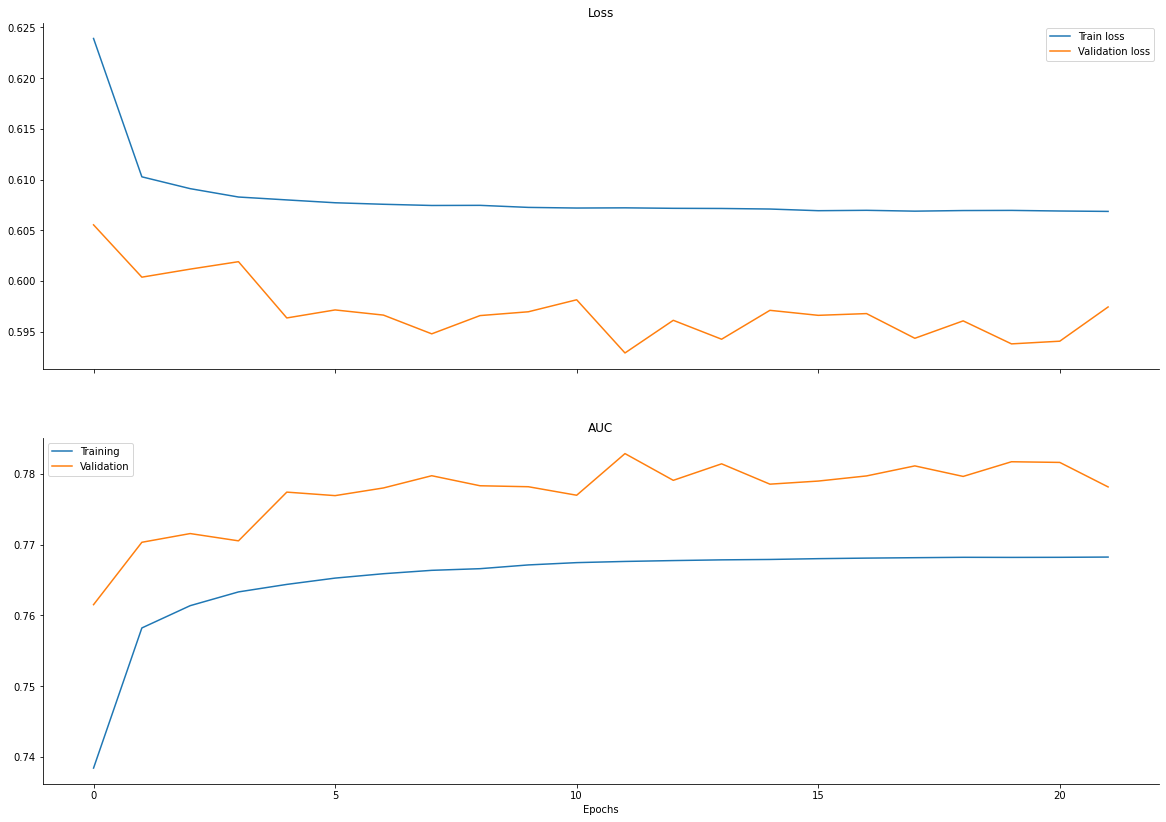

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auc'], label='Training')
ax2.plot(history['val_auc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('AUC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [11]:
model.evaluate(test_ds, verbose=1)

1075/1075 [==============================] - 33s 31ms/step - loss: 0.5922 - auc: 0.7837


[0.5921735763549805, 0.7837185859680176]

* baseline:                 loss: **0.4670 - auc: 0.8573**
* l2(0.001) reg  :          loss: 0.5910 - auc: 0.7741
* Dropout(0.5) :            loss: 0.4732 - auc: 0.8529
* Dropout(0.5), l2(0.0001): loss: 0.5922 - auc: 0.7837   